In [1]:
import cartopy

In [2]:
shapefile = cartopy.io.shapereader.natural_earth(resolution='50m', category='physical', name='coastline')

In [3]:
import cartopy.io.shapereader as shpreader

In [4]:
reader = shpreader.Reader(shapefile)
c = list(reader.records())

In [5]:
from matplotlib import pyplot as plt

In [6]:
len(c)

1428

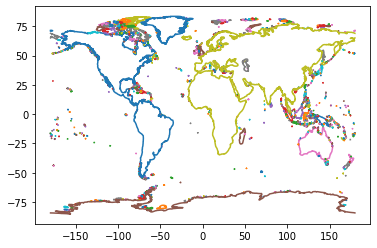

In [7]:
for n, _c in enumerate(c):
    try:
        plt.plot(*_c.geometry.xy)
    except:
        for __c in _c.geometry.geoms:
            plt.plot(*__c.xy)

In [8]:
from shapely.geometry import Polygon, LineString

In [9]:
# eurasia (cut of at the date line, but we ignore this for now
poly = Polygon(c[1387].geometry.geoms[1])

In [10]:
line = LineString([(160, 40), (-15, 45)])

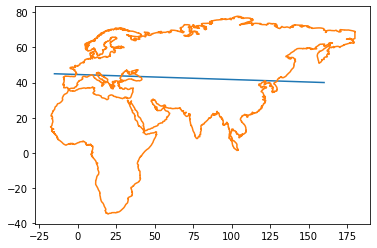

In [11]:
plt.plot(*line.xy)
plt.plot(*poly.exterior.xy)

In [12]:
all_points = set()

# original objects
all_points = all_points.union(set(list(zip(*poly.exterior.xy))))
all_points = all_points.union(set(list(zip(*line.xy))))

# intersection points
for n, g in enumerate(poly.difference(line.buffer(0.001)).geoms):
    all_points = all_points.union(set(list(zip(*g.exterior.xy))))

# round to get rid of degenerate points
all_points = set(map(lambda p: tuple(map(lambda t: round(t, 2), p)), all_points))

# sort from lower left corder to upper right corner
all_points = sorted(all_points)

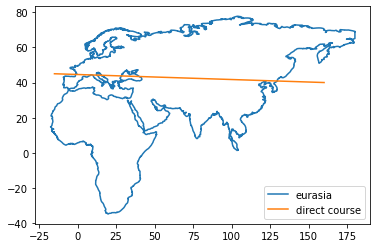

In [13]:
plt.plot(*poly.exterior.xy, label="eurasia")
plt.plot(*line.xy, label="direct course")

plt.legend(loc=0);

In [14]:
from shapely.ops import split

In [15]:
def get_all_poly_segments(poly=None, line=None):
    # split polygon into sub-polygons
    splits_0 = list(split(poly, line).geoms)
    
    # if only one resulting polygon, we're done here, return empty
    if len(splits_0) == 1:
        return []
    
    # turn polygons into line strings without the part covered by line
    splits_1 = [sp.exterior.difference(line.buffer(1e-14)) for sp in splits_0]
    
    # split possible line collections
    splits_2 = []
    for sp in splits_1:
        if hasattr(sp, "geoms"):
            for g in sp.geoms:
                splits_2.append(g)
        else:
            splits_2.append(sp)
        
    return splits_2

In [16]:
def get_all_line_segments(line=None, poly=None):
    # split polygon into sub-polygons
    splits_0 = list(split(line, poly).geoms)
    
    # if only one resulting polygon, we're done here, return empty
    if len(splits_0) == 1:
        return []
    
    # split possible line collections
    splits_1 = []
    for sp in splits_0:
        if hasattr(sp, "geoms"):
            for g in sp.geoms:
                splits_1.append(g)
        else:
            splits_1.append(sp)
        
    return list(zip(splits_1, map(lambda l: l.intersects(poly.buffer(-1.0e-7)), splits_1)))

In [17]:
all_poly_segments = get_all_poly_segments(poly, line)

all_poly_segments

In [18]:
all_line_segments = get_all_line_segments(line, poly)

all_line_segments

[(<shapely.geometry.linestring.LineString at 0x7f723c431580>, False),
 (<shapely.geometry.linestring.LineString at 0x7f723c431b50>, True),
 (<shapely.geometry.linestring.LineString at 0x7f723c431c10>, False),
 (<shapely.geometry.linestring.LineString at 0x7f723c431c40>, True),
 (<shapely.geometry.linestring.LineString at 0x7f723c431ca0>, False),
 (<shapely.geometry.linestring.LineString at 0x7f723c431d60>, True),
 (<shapely.geometry.linestring.LineString at 0x7f723c431b80>, False),
 (<shapely.geometry.linestring.LineString at 0x7f723c431bb0>, True),
 (<shapely.geometry.linestring.LineString at 0x7f723c4316a0>, False)]

In [19]:
import shapely.wkt

In [20]:
all_line_segments = [
    (shapely.wkt.loads(shapely.wkt.dumps(als[0], rounding_precision=5)), als[1])
    for als in all_line_segments
]

In [21]:
all_poly_segments = [
    shapely.wkt.loads(shapely.wkt.dumps(aps, rounding_precision=5))
    for aps in all_poly_segments
]

In [22]:
import networkx

In [23]:
from shapely.geometry import Point, LineString

In [24]:
class PointHash(Point):
    def __hash__(self):
        return hash(self.coords[0])
    
    
class LineStringHash(LineString):
    def __hash__(self):
        return hash(tuple(self.coords))

In [25]:
def _tupround(tup, n=0):
    return tup  #tuple(round(t, n) for t in tup)

In [26]:
def get_start_end(line, prec=5):
    return _tupround(line.coords[0], prec), _tupround(line.coords[-1], prec)

In [27]:
gg = networkx.MultiGraph()

In [28]:
for seg in all_poly_segments:
    gg.add_edge(
        PointHash(get_start_end(seg)[0]),
        PointHash(get_start_end(seg)[1]),
        key=LineStringHash(seg),
    )
    
for seg in all_line_segments:
    # skip if over land
    if seg[1]:
        continue
    gg.add_edge(
        PointHash(get_start_end(seg[0])[0]),
        PointHash(get_start_end(seg[0])[1]),
        key=LineStringHash(seg[0]),
    )

In [29]:
len(gg.edges)

13

In [30]:
len(gg.nodes)

10

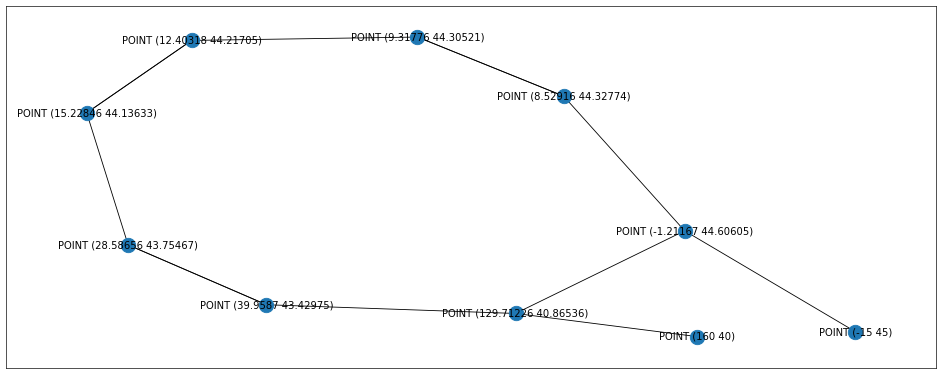

In [31]:
fig = plt.figure(1, figsize=(20, 8), dpi=60)
# nx.draw(G, with_labels=True, font_weight='normal')
networkx.draw_networkx(gg)

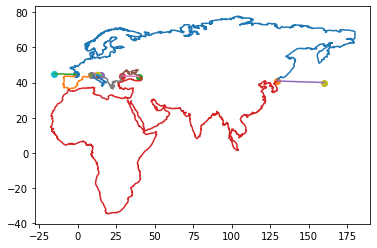

In [32]:
for n in gg.nodes:
    plt.plot(*n.xy, 'o')
    
for e in gg.edges:
    plt.plot(*e[2].xy, '-')

### Find all paths

In [33]:
from shapely.ops import linemerge

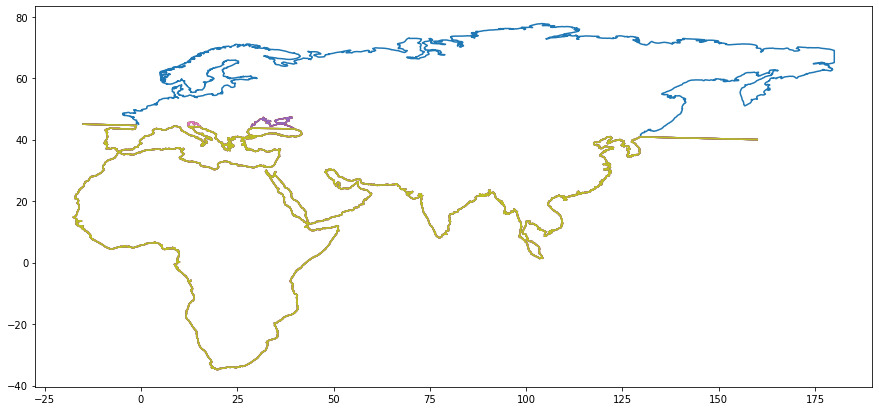

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
for _p in networkx.all_simple_edge_paths(gg, PointHash(*line.coords[0]), PointHash(line.coords[-1])):
    ax.plot(*linemerge([_l[2] for _l in _p]).xy)

In [35]:
paths = list(networkx.all_simple_edge_paths(gg, PointHash(*line.coords[0]), PointHash(line.coords[-1])))

In [36]:
len(paths) ** 0.5 // 1 + 1

4.0

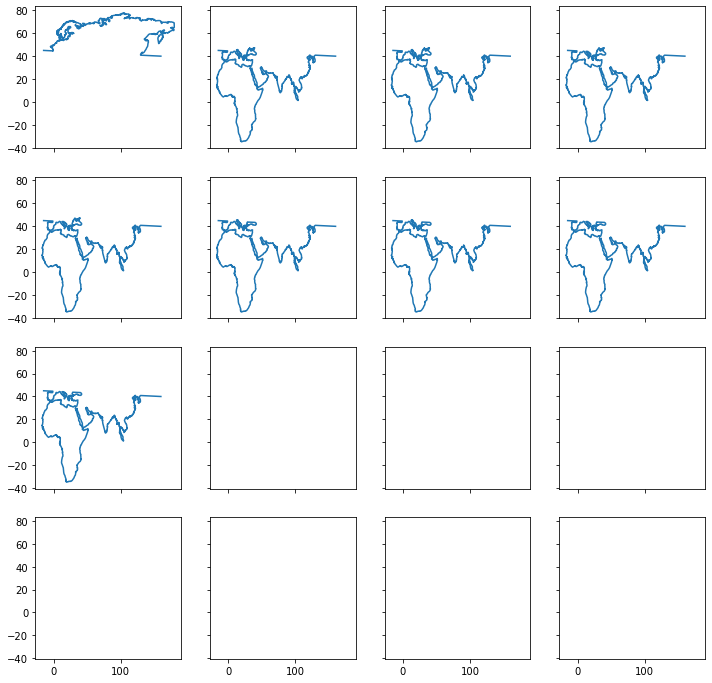

In [37]:
fig, ax = plt.subplots(
    int(len(paths) ** 0.5 // 1 + 1), int(len(paths) ** 0.5 // 1 + 1),
    figsize=(12, 12),
    sharex=True,
    sharey=True,
)
ax = ax.flatten()
for _p, _ax in zip(paths, ax):
    _ax.plot(*linemerge([_l[2] for _l in _p]).xy)